In [207]:
import pandas as pd
from datetime import timedelta
import datetime as dt
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

## Reading and displaying raw data

In [208]:
data = pd.read_csv('bedoccupancy.csv',
                   parse_dates=['ADMISSION_DATE_TIME', 'DISCHARGE_DATE_TIME'])

data = data.rename(columns={"Resident_Service.NAME": "residence", 
                     "ADMISSION_DATE_TIME": "ad_date_time",
                     "DISCHARGE_DATE_TIME": "dis_date_time"})

In [209]:
data.head()

,StudyID,residence,ad_date_time,dis_date_time
0,458495,Internal Medicine B,2014-04-01 02:15:00,2014-04-03 16:30:00
1,1212197,Internal Medicine D,2014-04-01 04:21:00,2014-04-17 22:37:00
2,507244,Internal Medicine D,2014-04-01 04:30:00,2014-04-03 17:05:00
3,202030,Internal Medicine E,2014-04-01 04:30:00,2014-04-04 17:12:00
4,460987,Internal Medicine C,2014-04-01 07:50:00,2014-04-08 19:15:00


## Length of Stay

In [210]:
data['los'] = data['dis_date_time']-data['ad_date_time']
data['los'] = data['los']/np.timedelta64(24,'h')

In [211]:
data.head()

,StudyID,residence,ad_date_time,dis_date_time,los
0,458495,Internal Medicine B,2014-04-01 02:15:00,2014-04-03 16:30:00,2.593750
1,1212197,Internal Medicine D,2014-04-01 04:21:00,2014-04-17 22:37:00,16.761111
2,507244,Internal Medicine D,2014-04-01 04:30:00,2014-04-03 17:05:00,2.524306
3,202030,Internal Medicine E,2014-04-01 04:30:00,2014-04-04 17:12:00,3.529167
4,460987,Internal Medicine C,2014-04-01 07:50:00,2014-04-08 19:15:00,7.475694


In [212]:
data['idx'] = pd.to_datetime(data['ad_date_time'])
data = data.set_index('idx')
data.head()

,StudyID,residence,ad_date_time,dis_date_time,los
idx,,,,,
2014-04-01 02:15:00,458495,Internal Medicine B,2014-04-01 02:15:00,2014-04-03 16:30:00,2.593750
2014-04-01 04:21:00,1212197,Internal Medicine D,2014-04-01 04:21:00,2014-04-17 22:37:00,16.761111
2014-04-01 04:30:00,507244,Internal Medicine D,2014-04-01 04:30:00,2014-04-03 17:05:00,2.524306
2014-04-01 04:30:00,202030,Internal Medicine E,2014-04-01 04:30:00,2014-04-04 17:12:00,3.529167
2014-04-01 07:50:00,460987,Internal Medicine C,2014-04-01 07:50:00,2014-04-08 19:15:00,7.475694


## CORRECT way of calculating bed occupancy

In [213]:
aux_1 = data['ad_date_time'].values
aux_2 = data['dis_date_time'].values

vaux_1 = np.ones(len(aux_1))
vaux_2 = -1*np.ones(len(aux_2))

aux = np.concatenate([aux_1, aux_2])
vaux = np.concatenate([vaux_1,vaux_2])

sort = np.argsort(aux)

aux = aux[sort]
vaux = vaux[sort]
bo = np.cumsum(vaux)

In [214]:
aux_dic = {'keys':aux, 'dates': aux, 'ad_dis': vaux, 'bo': bo}
df = pd.DataFrame.from_dict(aux_dic)
df = df.set_index('keys')

start_date = '2014-05-01'
end_date = '2019-04-01'
df = df[(df['dates'] > start_date) & (df['dates'] < end_date)]

In [215]:
df.head()

,dates,ad_dis,bo
keys,,,
2014-05-01 00:25:00,2014-05-01 00:25:00,1.0,90.0
2014-05-01 01:30:00,2014-05-01 01:30:00,1.0,91.0
2014-05-01 01:45:00,2014-05-01 01:45:00,1.0,92.0
2014-05-01 01:50:00,2014-05-01 01:50:00,1.0,93.0
2014-05-01 03:20:00,2014-05-01 03:20:00,1.0,94.0


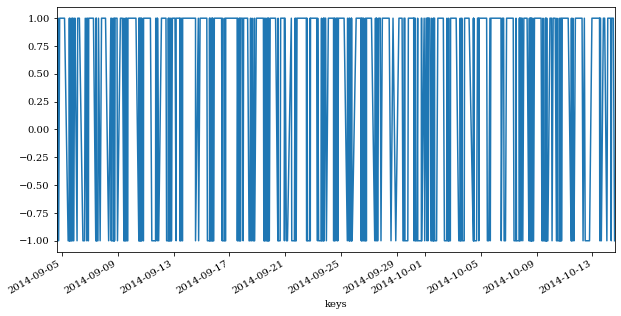

In [216]:
plt.figure(figsize=(10,5))
df['ad_dis'].iloc[3000:4000].plot()
plt.show()

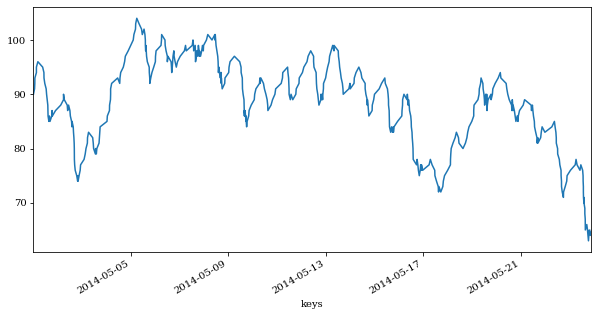

In [252]:
plt.figure(figsize=(10,5))
df['bo'].iloc[0:500].plot()
plt.show()

## Time deltas

In [218]:
aux_1 = data['ad_date_time'].values
aux_2 = data['dis_date_time'].values

vaux_1 = np.ones(len(aux_1))
vaux_2 = np.ones(len(aux_2))


sort_1 = np.argsort(aux_1)
sort_2 = np.argsort(aux_2)



aux_1 = aux_1[sort_1]
vaux_1 = vaux[sort_1]

aux_2 = aux_2[sort_2]
vaux_2 = vaux_2[sort_2]

In [219]:
aux_dic = {'keys':aux_1, 'dates': aux_1, 'ad_dis': vaux_1}
df_1 = pd.DataFrame.from_dict(aux_dic)
df_1 = df_1.set_index('keys')

In [220]:
aux_dic = {'keys':aux_2, 'dates': aux_2, 'ad_dis': vaux_2}
df_2 = pd.DataFrame.from_dict(aux_dic)
df_2 = df_2.set_index('keys')

In [221]:
df_1['delta'] = (df_1['dates']-df_1['dates'].shift()).fillna(pd.Timedelta('0 days'))
df_2['delta'] = (df_2['dates']-df_2['dates'].shift()).fillna(pd.Timedelta('0 days'))

#### Mean time between admissions

In [244]:
np.mean(df_1['delta'].dropna().values)

numpy.timedelta64(6496066707844,'ns')

In [245]:
print('Mean time between admissions (h):',6496066707844*1e-9/3600 )

Mean time between admissions: 1.8044629744011111


#### Mean time between discharges

In [247]:
np.mean(df_2['delta'].dropna().values)

numpy.timedelta64(6867602223594,'ns')

In [248]:
print('Mean time between admissions (h):',6867602223594*1e-9/3600 )

Mean time between admissions (h): 1.9076672843316669
